In [41]:
from tableBuilder import *
from classChildren import *
import math
from scipy.stats import norm
from scipy.stats import logistic
from scipy.stats import bernoulli
from scipy import special
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from debug import ipsh
import warnings
warnings.filterwarnings('ignore')

## Create Nash Child Class

As it is, $\theta = (a_R,a_L,a_C,b,c,\mu,s,p_C,\sigma,\epsilon)$.

In [96]:
class Nash(Bank):

    def I(self,a,b,c):
        return a+b*self.table['Inflation']+c*self.table['OutGap']

    def addZLZR(self,theta):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4]

        i = self.table['PriorTarget'].copy()
        self.table['zL'] = i-self.I(aL,b,c)
        self.table['zR'] = i-self.I(aR,b,c)
        
    def addILIR(self,theta,zeta='zeta'):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4]
        
        self.table['IL_'+zeta] = self.I(aL,b,c)+self.table[zeta]
        self.table['IR_'+zeta] = self.I(aR,b,c)+self.table[zeta]
        
    def G(self,theta,stepApprox=norm.cdf,zeta='zeta',target='Target'):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        self.table['G'] = stepApprox((self.I(aC,b,c)-self.table[target]+self.table[zeta])/eps)
        
        return self.table['G']
    
    def g(self,theta,zeta='zeta',target='Target',stepApproxPDF=norm.pdf):

        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        self.table['g'] = stepApproxPDF((self.I(aC,b,c)-self.table['Target']+self.table[zeta])/eps)
        
        return self.table['g']
    
    ######################################
    #                                    #
    #      Solving for rho and zeta      #
    #                                    #
    ######################################

    def guessRho(self,theta,zeta='zeta',target='target'):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        self.addZLZR(theta)
        rho = pd.Series([1-self.F(mu)]*self.table['Date'].size)
        self.table['rho_'+zeta] = rho.copy()

        return rho
    
    def giveZ(self,theta,plot=False,zeta='zeta',target='Target',rho='rho_zeta',chairman=False):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        self.table['ChangeSign'] = (self.table[target]-self.table['PriorTarget']).apply(np.sign)
        comm = 1/2*(self.table[target]-self.table['PriorTarget'])
        i = self.table[target].copy()
      
        B = 2*((self.I(aL,b,c)+self.I(aR,b,c))/2-i+1/2*comm)
        C = (self.I(aL,b,c)-i)*(self.I(aR,b,c)-i)+comm*(self.table[rho]*\
                    self.I(aL,b,c)+(1-self.table[rho])*self.I(aR,b,c)-i)

        if plot:
            self.addZLZR(theta)
            x = np.arange(-2,5,.1)
            y = x**2+B[1]*x+C[1]
            zero = np.zeros(x.size)
            fig, ax = plt.subplots()
            ax.plot(x,y)
            ax.plot(x,zero)
            ax.axvline(self.table['zL'][1],color='r')
            ax.axvline(self.table['zR'][1],color='m')
            plt.show()
        
        self.table[zeta] = pd.Series([0]*self.T)
        self.table[zeta][self.table['ChangeSign']==1] = (-B+(B**2-4*C)**(1/2))/2
        self.table[zeta][self.table['ChangeSign']==-1] = (-B-(B**2-4*C)**(1/2))/2
        return self.table[zeta]

        
    def giveRho(self,theta,zeta='zeta',target='Target',new=False,F=logistic.cdf):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        i = self.table[target].copy()
        
        if new:
            rho = pC*self.G(theta,zeta=zeta)+(1-pC)*((self.I(mu,b,c)+self.table['new_'+zeta]-i)/s).apply(F)
            rho[rho>1]=1; rho[rho<0]=0
            self.table['newRho_'+zeta] = rho.copy()
            
        else:
            rho = pC*self.G(theta,zeta=zeta)+(1-pC)*((self.I(mu,b,c)+self.table[zeta]-i)/s).apply(F)
            rho[rho>1]=1; rho[rho<0]=0
            self.table['rho_'+zeta] = rho.copy()   
        
        return rho
    
    
    def getRhoZHelper(self,theta,zeta='zeta',target='Target',conv=0.0001,printN=False,n=0):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        n+=1
        
        newZeta = 'new_'+zeta
        self.giveZ(theta,zeta=newZeta,target=target,rho='rho_'+zeta)
        self.giveRho(theta,zeta=zeta,target=target,new=True)
        
        if n==100:
            print('fooooooooork')
            ipsh()
        
        if target!='Target':
            rhoConv = all((self.table['rho_'+zeta]-self.table['newRho_'+zeta])\
                      [(self.table['Chairman_'+zeta]==0)].apply(abs)<conv)
            zConv = all((self.table[zeta]-self.table[newZeta])\
                    [(self.table['Chairman_'+zeta]==0)].apply(abs)<conv)
            
        else:                             
            rhoConv = all((self.table['rho_'+zeta]-self.table['newRho_'+zeta])\
                          [(self.table['ChangeSign']!=0)&(self.table['Chairman_'+zeta]==0)].apply(abs)<conv)
            zConv = all((self.table[zeta]-self.table[newZeta])\
                        [(self.table['ChangeSign']!=0)&(self.table['Chairman_'+zeta]==0)].apply(abs)<conv)
            
        if n==100:
            ipsh()
            
        self.table[zeta] = self.table[newZeta].copy(); self.table = self.table.drop([newZeta],axis=1)
        self.table['rho_'+zeta] = self.table['newRho_'+zeta].copy(); self.table = self.table.drop(['newRho_'+zeta],axis=1) 
        
        try:
            self.table[zeta][self.table['Chairman_'+zeta]==1]=\
            -(aC+b*self.table['Inflation']+c*self.table['OutGap']-self.table[target])
        except:
            pass
       
        if (rhoConv,zConv) == (True,True):
            if printN:
                print(n)
            return self.table
            
        return self.getRhoZHelper(theta,zeta,target,conv,printN,n)
    
    def chairmanHelper(self,theta,zeta='zeta'):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        self.table['Chairman_'+zeta] = pd.Series([0]*self.T)
        self.table['lower'] = pd.Series([(1-pC)*self.F((mu-aC)/s)]*self.T)
        self.table['upper'] = pd.Series([pC+(1-pC)*self.F((mu-aC)/s)]*self.T)
        self.giveZ(theta,zeta='lowerZ',rho='lower')
        self.giveZ(theta,zeta='upperZ',rho='upper')
        self.table['atLower'] = (self.table['Target']-b*self.table['Inflation']-c*self.table['OutGap']-self.table['lowerZ']).copy()       
        self.table['atUpper'] = (self.table['Target']-b*self.table['Inflation']-c*self.table['OutGap']-self.table['upperZ']).copy()
        self.dropCols(['lower','upper','lowerZ','upperZ'])
        
        try:
            self.table['Chairman_'+zeta][(aC<self.table['atUpper']) & (aC>self.table['atLower'])]=1
        except:
            pass
                
    def makeGrid(self,theta,binSize=2,pC_binSize=0.4,numDraws=40):

        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        params = np.array([aR,aL,aC,b,c,mu,s,pC,sigma])
        grids = []
        for i in range(len(theta)-1):
            grids.append([])
            for j in range(numDraws):
                if i==6 or i==8:
                    grids[i].append(random.uniform(max(params[i]-binSize,0),params[i]+binSize))
                elif i==7:
                    grids[i].append(random.uniform(max(params[i]-pC_binSize,0),min(params[i]+pC_binSize,1)))
                else:
                    grids[i].append(random.uniform(params[i]-binSize,params[i]+binSize))
            
        self.grid = pd.DataFrame(np.transpose(np.array(grids)))
        self.grid.columns = ['aR','aL','aC','b','c','mu','s','pC','sigma']
        return(self.grid)
    
    def computeGridLL(self,theta,**grid_kwargs):

        self.makeGrid(theta,**grid_kwargs)
        params = {0:'aR',1:'aL',2:'aC',3:'b',4:'c',5:'mu',6:'s',7:'pC',8:'sigma'}
        
        def makeThetaLL(row):
            rowTheta = row.values
            rowTheta = np.append(rowTheta,theta[-1])
            try:
                return self.lln(rowTheta)
            except:
                return None
                
        self.grid['LL'] = self.grid.apply(lambda row: makeThetaLL(row), axis=1)
        return(self.grid)
    
    def checkParams(self,theta):
        
        if theta[6]<0:
            theta[6]=0
        
        if theta[7]>1:
            theta[7]=1
            
        elif theta[7]<0:
            theta[7]=0
            
        if theta[8]<0:
            theta[8]=0
            
        return theta
            
    def searchWeights(self,n):
        
        if n<=20:
            return 1
        elif n<=30:
            return 0.5
        elif n<=40:
            return 0.25
        elif n<=60:
            return 0.125
        elif n<=80:
            return 0
    
    def gradAscentNash(self,alpha,estimate,conv = 0.0001,ll=False,est=False,n=1,m=0,v=0,beta_1=0.9,beta_2=0.999,**grid_kwargs):
        
        anotherEpsilon = 10e-8
        estimate=self.checkParams(estimate)
        
        #numDraws=10,binSize=2*random.uniform(.25,1),pC_binSize=0.4*random.uniform(0.25,1)

        if n%10==1 and n<70:
            self.computeGridLL(estimate,**grid_kwargs)
            row = self.grid['LL'].argmax()
            newEstimate = self.grid.loc[row].copy().values
            newEstimate[-1] = estimate[-1]
            if self.grid['LL'].max()>self.lln(estimate):
                estimate = newEstimate
        
        if est:
            print(estimate)
        
        # adapted from https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c
        gradient = self.gradNash(estimate)
        m = beta_1 * m + (1 - beta_1) * gradient
        m_tild = beta_1*m + (1-beta_1)*gradient
        v = beta_2 * v + (1 - beta_2) * np.power(gradient, 2)
        m_hat = m_tild / (1 - np.power(beta_1, n))
        v_hat = v / (1 - np.power(beta_2, n))
        w = alpha*m_hat / (np.sqrt(v_hat) + anotherEpsilon)

        update = estimate[0:-1]+w
        update = np.append(update,estimate[-1])
        
        update = self.checkParams(update)
        
        theta=self.checkParams(estimate)

        priorLL = self.lln(estimate)
        newLL = self.lln(update)

        improve = newLL>priorLL

        n+=1

        if ll:
            print(newLL)

        if improve:    
            if abs(newLL-priorLL)<=conv:
                return update

        return(self.gradAscentNash(alpha,update,conv,ll,est,n,m,v))

        #return self.gradAscentNash(worseWeight*alpha,estimate,conv,ll,est,worseWeight,betterWeight,n,m,v)
            
    
    def compareGradToLLN(self,theta,epsilon=0.00001,delta=0.001,start=0,end=9):
        
        params = {0:'aR',1:'aL',2:'aC',3:'b',4:'c',5:'mu',6:'s',7:'pC',8:'sigma'}
        
        good = True
        grad = self.gradNash(theta)
        
        for i in range(start,end):
            beta = theta[:]
            beta[i] = beta[i]+epsilon
            
            if abs(self.gradNash(theta)[i]-(self.lln(beta)-self.lln(theta))/epsilon)>=delta:
                print(params[i])
                print(grad[i])
                print(((self.lln(beta)-self.lln(theta))/epsilon))
                good = False
                
        print('Done!')       
        if good:
            print("You're all good!")
            
    def checkGradImprovingNash(self,theta,epsilon=0.00001,start=0,end=9):
        
        good = True
        llh = self.lln(theta)
        
        for i in range(start,end):
            blarp = theta[:]
            blarp[i] = blarp[i]+epsilon*self.gradNash(theta)[i]
            if (self.lln(blarp)<llh):
                good = False
                print(i)
        
        print('Done!')       
        if good:
            print("You're all good!")
            
    def allEstimates(self,theta,samples=10,increment=0.001):
        
        all_zeta = norm.rvs(loc=theta[-4], scale=theta[-3], size=samples)
        
        hessians = []
        for zetas in all_zeta:
            hessians.append(self.singleEstimate(theta,zetas,increment))
            
        return(hessians)
            
        
    def singleEstimate(self,theta,z,increment):
            
        weights = 2*((bernoulli.rvs(0.5,size=len(theta)))-0.5) * increment
        
        theta_lower = theta-weights
        theta_upper = theta-weights
        
        grad_lower = np.reshape(self.gradNash(theta_lower,mc_z=z),(len(self.gradNash(theta_lower,mc_z=z)),1))
        grad_upper = np.reshape(self.gradNash(theta_upper,mc_z=z),(len(self.gradNash(theta_upper,mc_z=z)),1))
        
        reg_1 = self.table.where(self.table['ChangeSign']==1).copy()
        reg_2 = self.table.where(self.table['ChangeSign']==0).copy()
        reg_3 = self.table.where(self.table['ChangeSign']==-1).copy()
        
        ipsh()
        
        estimate = 0.5 * (np.matmul((grad_upper/2),(1/weights)) + 
                          np.transpose(np.matmul((grad_lower/2),(1/weights)))) 
        return(estimate)
                            
            
#Fed = Nash('Fed2',trunc=(7,None),dropCols=['Change','Tau'])

In [90]:
BoC.gradNash(theta,mc_z=0.5)

array([ 1.98988874e+00,  7.66137536e+00,  8.56610566e-17,  2.00705643e+01,
       -5.87490377e-01, -1.96952585e-02,  1.71482135e-02,  9.12037057e-01,
       -5.53691920e+01])

In [98]:
BoC.allEstimates(theta)

** ENTERING NESTED INTERPRETER **
Hit Ctrl-D to exit interpreter and continue program.
Note that if you use %kill_embedded, you can fully deactivate
This embedded instance so it will never turn on again.

Stopped at <ipython-input-96-b869f1768c65> at line 353

In [1]: grad_upper
Out[1]: 
array([[ 1.20851970e+02],
       [ 1.21566399e+02],
       [-3.41125120e-30],
       [ 5.68045228e+02],
       [-1.30595114e+01],
       [-1.43264875e-03],
       [ 2.99754410e-03],
       [-2.18726041e-02],
       [ 1.89959361e+03]])

In [2]: len(grad_upper)
Out[2]: 9

In [3]: len(weights)
Out[3]: 10

In [4]: weights
Out[4]: 
array([-0.001,  0.001,  0.001,  0.001, -0.001, -0.001, -0.001, -0.001,
       -0.001,  0.001])

In [5]: weights = weights[:-1]

In [6]: np.matmul(grad_upper,weights)
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-6-988466d46517> in <module>
----> 1 np.matmul(gra

KeyboardInterrupt: 

In [97]:
class Continuous(Nash):
    
    def getRhoZ(self,theta,**helper_kwargs):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
                      
        self.guessRho(theta)
        self.giveZ(theta)
        self.giveRho(theta)
        self.chairmanHelper(theta)
        self.getRhoZHelper(theta,**helper_kwargs) 
        self.addZLZR(theta)
        self.addILIR(theta)
        
        try:
            self.table['zeta'][self.table['ChangeSign']==0]=None; self.table['rho_zeta'][self.table['ChangeSign']==0]=None
            self.table['rho_zeta'][self.table['Chairman_zeta']==1]=None
        except:
            pass
            
        self.dropCols(['atLower','atUpper'])
        
        return self.table
    
    def lln(self,theta):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        self.getRhoZ(theta)

        sumOne = -1/(2*sigma**2)*(self.table['zeta'].where(self.table['ChangeSign']!=0)**2).sum()
        sumTwo =  ((self.table['zR']/sigma).where(self.table['ChangeSign']==0).apply(norm.cdf)\
                -(self.table['zL']/sigma).where(self.table['ChangeSign']==0).apply(norm.cdf)).apply(math.log).sum()

        return(-self.T*(1/2*math.log(2*math.pi)+math.log(sigma))+sumOne+sumTwo)


    def gradNashFirst(self,theta): 
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        i = self.table['Target'].copy(); z = self.table['zeta'].copy(); rho = self.table['rho_zeta'].copy()

        comm = 1/2*(self.table['Target']-self.table['PriorTarget'])
        den = 2*(z+(self.I(aL,b,c,)+self.I(aR,b,c))/2-i)+\
                comm+comm*(aL-aR)*(pC/eps*self.g(theta)+(1-pC)/s*self.f((self.I(mu,b,c)+z-i)/s))

        dZdaR = -(z+(self.I(aL,b,c)-i)+comm*(1-rho))/den
        dZdaL = -(z+(self.I(aR,b,c)-i)+comm*rho)/den
        dZdaC = -pC/eps*self.g(theta)*comm*(aL-aR)*(-1)
        dZdMu = -(1-pC)/s*comm*(aL-aR)*self.f((self.I(mu,b,c)+z-i)/s)/den
        dZdS = (comm*(1-pC)*(aL-aR)*((self.I(mu,b,c)+z-i)/s**2)*\
                self.f((self.I(mu,b,c)+z-i)/s))/den
        dZdpC = -comm*(aL-aR)*(self.G(theta)-self.F((self.I(mu,b,c)+z-i)/s))/den

        gradaR = -(z*dZdaR)/sigma**2
        gradaL = -(z*dZdaL)/sigma**2
        gradaC = -(z*dZdaC)/sigma**2
        gradB = (z*self.table['Inflation'])/sigma**2
        gradC = (z*self.table['OutGap'])/sigma**2
        gradMu = -(z*dZdMu)/sigma**2
        gradS = -(z*dZdS)/sigma**2
        gradpC = -(z*dZdpC)/sigma**2
        gradSigma = (z**2)/sigma**3

        return(gradaR,gradaL,gradaC,gradB,gradC,gradMu,gradS,gradpC,gradSigma)

    def gradNashSecond(self,theta):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        numr = (self.table['zR']/sigma).apply(norm.pdf)-(self.table['zL']/sigma).apply(norm.pdf)
        den = (self.table['zR']/sigma).apply(norm.cdf)-(self.table['zL']/sigma).apply(norm.cdf)
        
        gradaR = -1/sigma*((self.table['zR']/sigma).apply(norm.pdf)/den)
        gradaL = 1/sigma*((self.table['zL']/sigma).apply(norm.pdf)/den)
        gradaC = pd.Series([0]*self.T)
        gradB = -1/sigma*(self.table['Inflation']*numr/den)
        gradC = -1/sigma*(self.table['OutGap']*numr/den)
        gradMu = pd.Series([0]*self.T)
        gradS = pd.Series([0]*self.T)
        gradpC = pd.Series([0]*self.T)
        gradSigma = -1/(sigma**2)*(self.table['zR']*(self.table['zR']/sigma).apply(norm.pdf)-\
                                 self.table['zL']*(self.table['zL']/sigma).apply(norm.pdf))/den

        return(gradaR,gradaL,gradaC,gradB,gradC,gradMu,gradS,gradpC,gradSigma)
    
    def gradNashThird(self,theta):
        
        i = self.table['Target'].copy(); z = self.table['zeta'].copy(); rho = self.table['rho_zeta'].copy()
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        gradaR = pd.Series([0]*self.T)
        gradaL = pd.Series([0]*self.T)
        gradaC = z/sigma**2
        gradB = (z*self.table['Inflation'])/sigma**2
        gradC = (z*self.table['OutGap'])/sigma**2
        gradMu = pd.Series([0]*self.T)
        gradS = pd.Series([0]*self.T)
        gradpC = pd.Series([0]*self.T)
        gradSigma = (z**2)/sigma**3
        
        return(gradaR,gradaL,gradaC,gradB,gradC,gradMu,gradS,gradpC,gradSigma)

    def gradNash(self,theta,mc_z=None,**getRhoZ_kwargs):
        
        sigma = theta[-2]
        if mc_z is None:
            self.getRhoZ(theta,**getRhoZ_kwargs)
        else:
            self.table['zeta'] = [mc_z]*self.T
            self.giveRho(theta)
            self.chairmanHelper(theta)
            self.addZLZR(theta)
            self.addILIR(theta)
        
        gradaR=0.0; gradaL=0.0; gradaC=0.0; gradB=0.0; gradC=0.0; gradMu=0.0; gradS=0.0; gradpC=0.0; gradSigma=0.0
        grads = np.array([gradaR, gradaL, gradaC, gradB, gradC, gradMu, gradS, gradpC, gradSigma])
        for i in range(len(theta)-1):
            
            grads[i] = self.gradNashFirst(theta)[i].where(self.table['ChangeSign']!=0).where(self.table['Chairman_zeta']==0).sum()+\
                     self.gradNashSecond(theta)[i].where(self.table['ChangeSign']==0).sum()+\
                     self.gradNashThird(theta)[i].where(self.table['ChangeSign']!=0).where(self.table['Chairman_zeta']==1).sum()
        
        grads[8]=grads[8]-self.T/sigma
        
        return(grads)

BoC = Continuous('BoC',cpiType='TotalCPI',lam=129600,trunc=(12,None),dropCols=['TotalCPI','TotalCPI_SA','Change','Tau'])

In [4]:
class Discrete(Nash):
    
    def getRhoZ(self,theta,**helper_kwargs):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        self.table['T_high'] = self.table['Target']+0.125
        self.table['T_low'] = self.table['Target']-0.125
        self.table['ChangeSign']
        
        self.guessRho(theta,zeta='zetaHigh')
        self.giveZ(theta,zeta='zetaHigh',target='T_high',rho='rho_zetaHigh')
        self.giveRho(theta,zeta='zetaHigh',target='T_high')
        
        self.guessRho(theta,zeta='zetaLow')
        self.giveZ(theta,zeta='zetaLow',target='T_low',rho='rho_zetaLow')
        self.giveRho(theta,zeta='zetaLow',target='T_low')
        
        self.chairmanHelper(theta,zeta='zetaHigh')
        self.chairmanHelper(theta,zeta='zetaLow')
        
        self.getRhoZHelper(theta,zeta='zetaHigh',target='T_high',**helper_kwargs) 
        self.getRhoZHelper(theta,zeta='zetaLow',target='T_low',**helper_kwargs) 

        self.addZLZR(theta)
        self.addILIR(theta,zeta='zetaHigh')
        self.addILIR(theta,zeta='zetaLow')
        
        try:
            self.table['rho_zetaHigh'][self.table['Chairman_zetaHigh']==1]=None
            self.table['rho_zetaLow'][self.table['Chairman_zetaLow']==1]=None

        except:
            pass
            
        self.dropCols(['atLower','atUpper'])
        
    def lln(self,theta):
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
    
        self.getRhoZ(theta)
        
        llh =  ((self.table['zetaHigh']/sigma).apply(norm.cdf)\
                -(self.table['zetaLow']/sigma).apply(norm.cdf)).apply(math.log).sum()

        return(llh)


    def dZ(self,theta,target,zeta): 
        
        aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
        mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]
        
        i = self.table[target].copy(); z = self.table[zeta].copy(); rho = self.table['rho_'+zeta].copy()

        comm = 1/2*(self.table[target]-self.table['PriorTarget'])
        den = 2*(z+(self.I(aL,b,c,)+self.I(aR,b,c))/2-i)+\
                comm+comm*(aL-aR)*(pC/eps*self.g(theta,zeta=zeta)+(1-pC)/s*self.f((self.I(mu,b,c)+z-i)/s))

        dZdaR = -(z+(self.I(aL,b,c)-i)+comm*(1-rho))/den
        dZdaL = -(z+(self.I(aR,b,c)-i)+comm*rho)/den
        dZdaC = -pC/eps*self.g(theta,zeta=zeta)*comm*(aL-aR)*(-1)
        dZdB = -self.table['Inflation']
        dZdC = -self.table['OutGap']
        dZdMu = -(1-pC)/s*comm*(aL-aR)*self.f((self.I(mu,b,c)+z-i)/s)/den
        dZdS = (comm*(1-pC)*(aL-aR)*((self.I(mu,b,c)+z-i)/s**2)*\
                self.f((self.I(mu,b,c)+z-i)/s))/den
        dZdpC = -comm*(aL-aR)*(self.G(theta,zeta=zeta)-self.F((self.I(mu,b,c)+z-i)/s))/den
        
        dZdaR[self.table['Chairman_'+zeta]==1]=0
        dZdaL[self.table['Chairman_'+zeta]==1]=0
        dZdaC[self.table['Chairman_'+zeta]==1]=-1
        dZdMu[self.table['Chairman_'+zeta]==1]=0
        dZdS[self.table['Chairman_'+zeta]==1]=0
        dZdpC[self.table['Chairman_'+zeta]==1]=0
        
        return(dZdaR,dZdaL,dZdaC,dZdB,dZdC,dZdMu,dZdS,dZdpC)

    def gradNash(self,theta):
        
        sigma = theta[-2]
        self.getRhoZ(theta)
        
        gradaR=0.0; gradaL=0.0; gradaC=0.0; gradB=0.0; gradC=0.0; gradMu=0.0; gradS=0.0; gradpC=0.0; gradSigma=0.0
        dZ_high = np.array(self.dZ(theta,'T_high','zetaHigh'))
        dZ_low = np.array(self.dZ(theta,'T_low','zetaLow'))
        grads = np.array([gradaR, gradaL, gradaC, gradB, gradC, gradMu, gradS, gradpC, gradSigma])
        for i in range(len(grads)-1): 
            grads[i] = 1/sigma * (((self.table['zetaHigh']/sigma).apply(norm.pdf)*dZ_high[i]-(self.table['zetaLow']/sigma).apply(norm.pdf)*dZ_low[i])/\
            ((self.table['zetaHigh']/sigma).apply(norm.cdf)-(self.table['zetaLow']/sigma).apply(norm.cdf))).sum()

        grads[-1]= -1/sigma**2 * (((self.table['zetaHigh']/sigma).apply(norm.pdf)*self.table['zetaHigh']\
                                -(self.table['zetaLow']/sigma).apply(norm.pdf)*self.table['zetaLow'])/\
                                ((self.table['zetaHigh']/sigma).apply(norm.cdf)-(self.table['zetaLow']/sigma).apply(norm.cdf))).sum()
        
        return(grads)
    
    
BoC = Discrete('BoC',cpiType='TotalCPI',lam=129600,trunc=(12,None),dropCols=['TotalCPI','TotalCPI_SA','Change','Tau'])

In [9]:
BoC.compareGradToLLN(theta,epsilon=0.000000001)

aR
85.23131928277961
30.407704798562914
aL
-31.391224445507632
-31.387230592372358
aC
-0.003971570222163847
0.00011368683772161602
b
151.26444292908243
65.5013536743354
c
-19.01199073158295
-41.497401070955675
mu
0.0864653240683814
0.07048583938740194
s
0.2656504651882465
0.2879687599488534
pC
-3.619818784362465
-3.9941596696735355
sigma
422.67428077553507
315.792362926004
Done!


In [74]:
BoC.compareGradToLLN(theta,epsilon=0.000000001,start=8,end=9)

Done!
You're all good!


In [8]:
#BoC
#theta = [2.87094784, 4.506676, 4.4, -0.17693375, -0.95165285, 5, 1.36465979, 0.2, 0.80543946,0.1]

#Fed
### theta = [1.02956614,3.79123651, 2.12936925, 0.67814839, -2.68600361,1.31300212, 2.59155696, 1., 1.02428965, 0.1 ]

theta = [0.1 , 5 , 1.2 , 0 ,-0.4 , 1 ,3 , 0.6 , 0.8 , 0.2]
#theta = [1.66836163,  3.71916583,  1.95626927,  0.19763735, -1.05312647,  2.01352984,3.1512265,   0.65155844,  1.20431678,  0.2  ]
#theta = [1.66836163,  3.71916583,  3.719,  0.19763735, -1.05312647,  2.01352984,3.1512265,   0.65155844,  1.20431678,  0.2  ]
### theta = [0.97870149, 3.74690127, 2.40183283, 0.69090601, -2.71082351, -0.47811126, 3.50354155, 1., 1.02244263, 0.2]

## Grad Ascent MLE

In [10]:
BoC.gradAscentNash(0.01,theta,ll=True,est=True,conv=0.0001,numDraws=10,binSize=2*random.uniform(.25,1),pC_binSize=0.4*random.uniform(0.25,1)) # total

[-0.61741999  4.48280419  0.72513295  0.40462868  0.36588141  0.60270516
  2.92280711  0.73671419  1.57873727  0.2       ]
-160.61235366372858
[-0.59841999  4.46380419  0.70626702  0.42362868  0.34688141  0.58370518
  2.94180711  0.71771419  1.59773727  0.2       ]
-159.18470785858008
[-0.58432101  4.44955159  0.69095685  0.43758202  0.33274131  0.56924728
  2.9562007   0.70343722  1.61170331  0.2       ]
-157.9847531942907
[-0.57184058  4.43687597  0.67719884  0.44986508  0.3202067   0.55632643
  2.96904545  0.69073062  1.62401067  0.2       ]
-156.91544987294128
[-0.5601793   4.42498583  0.66430592  0.46128132  0.30847994  0.54416466
  2.98112348  0.67880437  1.63546483  0.2       ]
-155.93774088136297
[-0.5490232   4.41356507  0.65195251  0.47213911  0.29724608  0.53244536
  2.99275125  0.66734211  1.64637732  0.2       ]
-155.03162826953263
[-0.53821861  4.402456    0.63995193  0.48258408  0.28634988  0.52100802
  3.00408838  0.65618556  1.65689768  0.2       ]
-154.18522244449102


-124.03735205514589
[ 0.78122994  3.15593919 -1.09166971  0.54079064 -0.90733124  0.5179967
  3.69499733  0.26226706  1.37383194  0.2       ]
-123.97298056332616
[ 0.78521647  3.15152357 -1.09174134  0.54055073 -0.90762757  0.52775903
  3.70351026  0.26312234  1.36810788  0.2       ]
-123.9089481147179
[ 0.78927744  3.14712342 -1.09180636  0.54041781 -0.90791161  0.53760996
  3.71197912  0.26396179  1.36239898  0.2       ]
-123.84527839929684
[ 0.79341105  3.14273398 -1.09186536  0.54038324 -0.90818265  0.54754413
  3.72040367  0.26478452  1.35670844  0.2       ]
-123.78200159583348
[ 0.79761508  3.13835027 -1.0919189   0.54043722 -0.90843974  0.55755616
  3.72878366  0.2655898   1.3510392   0.2       ]
-123.71915262482702
[ 0.80188691  3.13396727 -1.09196748  0.54056896 -0.90868173  0.56764069
  3.73711886  0.26637701  1.34539405  0.2       ]
-123.6567692544034
[ 0.80622364  3.12957996 -1.09201155  0.54076701 -0.90890735  0.57779243
  3.74540905  0.26714564  1.33977557  0.2       ]
-1

-121.45727322076762
[ 1.06431282  2.91758963 -1.09243578  0.5320142  -0.89160472  1.13734464
  4.11609137  0.27506397  1.11470822  0.2       ]
-121.43647651168396
[ 1.0691201   2.91548597 -1.092436    0.53143105 -0.89098542  1.14810201
  4.122194    0.27459537  1.11192558  0.2       ]
-121.41631962028576
[ 1.07389616  2.91350051 -1.09243621  0.53082804 -0.890368    1.15883715
  4.12826569  0.27411072  1.10920563  0.2       ]
-121.39678185309788
[ 1.07864052  2.91163399 -1.09243639  0.53020591 -0.8897533   1.16954909
  4.13430701  0.27361068  1.1065484   0.2       ]
-121.37784227171689
[ 1.08335277  2.90988701 -1.09243656  0.52956549 -0.88914215  1.18023687
  4.1403185   0.27309595  1.10395387  0.2       ]
-121.35947976225451
[ 1.08803256  2.90825999 -1.09243671  0.52890763 -0.88853535  1.19089955
  4.14630073  0.27256723  1.10142199  0.2       ]
-121.34167310629796
[ 1.09267961  2.90675314 -1.09243685  0.52823317 -0.8879337   1.2015362
  4.15225425  0.27202523  1.09895268  0.2       ]


-120.7950510961146
[ 1.29139412  2.95431654 -1.09243813  0.47904153 -0.87049281  1.7020385
  4.4351495   0.24309068  1.03884024  0.2       ]
-120.78787460683601
[ 1.29455134  2.95656749 -1.09243813  0.4779826  -0.87038322  1.7105241
  4.44027534  0.24277034  1.03848346  0.2       ]
-120.78077135639633
[ 1.29769072  2.95883036 -1.09243813  0.47692526 -0.87027746  1.71896936
  4.44539433  0.24246357  1.03813814  0.2       ]
-120.77374086331213
[ 1.30081258  2.96110366 -1.09243813  0.47586973 -0.87017528  1.72737476
  4.45050662  0.24217037  1.03780361  0.2       ]
-120.7667826684066
[ 1.30391721  2.96338594 -1.09243813  0.47481626 -0.87007643  1.73574081
  4.45561232  0.24189069  1.03747921  0.2       ]
-120.75989632991437
[ 1.30700489  2.96567584 -1.09243813  0.47376506 -0.86998068  1.74406801
  4.46071156  0.2416245   1.03716432  0.2       ]
-120.7530814192569
[ 1.31007588  2.96797204 -1.09243813  0.47271632 -0.8698878   1.7523569
  4.46580445  0.24137174  1.03685834  0.2       ]
-120.

-120.48625765712515
[ 1.44946405  3.0794305  -1.09243813  0.42406281 -0.86630323  2.14464015
  4.7227663   0.24257768  1.02614564  0.2       ]
-120.48258542094266
[ 1.45176135  3.08129989 -1.09243813  0.42325881 -0.86624278  2.15168435
  4.72755584  0.24278066  1.02599018  0.2       ]
-120.47895948435335
[ 1.45404386  3.08315816 -1.09243813  0.42245988 -0.86618271  2.15871701
  4.73233942  0.24298711  1.02583636  0.2       ]
-120.47537936242382
[ 1.45631155  3.08500534 -1.09243813  0.42166603 -0.86612303  2.16573842
  4.73711702  0.2431969   1.02568419  0.2       ]
-120.4718445712645
[ 1.45856441  3.08684146 -1.09243813  0.42087726 -0.86606375  2.17274883
  4.74188862  0.2434099   1.02553369  0.2       ]
-120.46835462810941
[ 1.46080244  3.08866654 -1.09243813  0.42009355 -0.86600487  2.17974853
  4.74665423  0.24362598  1.02538485  0.2       ]
-120.46490905139703
[ 1.46302564  3.09048061 -1.09243813  0.41931489 -0.86594641  2.18673775
  4.75141384  0.24384501  1.0252377   0.2       ]


-120.33562152576853
[ 1.55867645  3.17010079 -1.09243813  0.38555269 -0.86351258  2.53994242
  4.99066464  0.25727036  1.01977862  0.2       ]
-120.33389567871471
[ 1.560151    3.17135692 -1.09243813  0.38502698 -0.86347663  2.5465894
  4.99511005  0.25754387  1.0197096   0.2       ]
-120.33219180662512
[ 1.56161274  3.17260305 -1.09243813  0.38450567 -0.86344104  2.55323209
  4.99954976  0.25781745  1.01964166  0.2       ]
-120.33050958348444
[ 1.56306174  3.17383922 -1.09243813  0.38398873 -0.8634058   2.55987054
  5.00398379  0.25809109  1.01957477  0.2       ]
-120.32884868684638
[ 1.56449806  3.17506545 -1.09243813  0.38347614 -0.86337092  2.56650478
  5.00841213  0.25836477  1.01950892  0.2       ]
-120.32720879783183
[ 1.56592177  3.17628178 -1.09243813  0.38296788 -0.86333639  2.57313486
  5.01283481  0.25863847  1.0194441   0.2       ]
-120.32558960112564
[ 1.56733292  3.17748824 -1.09243813  0.38246394 -0.86330221  2.57976082
  5.01725183  0.2589122   1.01938028  0.2       ]


-120.26325631852215
[ 1.62506961  3.22763761 -1.09243813  0.36168544 -0.86194181  2.9193448
  5.2394085   0.27294866  1.01716207  0.2       ]
-120.262371434712
[ 1.62591167  3.22838213 -1.09243813  0.36137962 -0.86192259  2.92579055
  5.24354092  0.27321193  1.01713591  0.2       ]
-120.26149510697606
[ 1.62674485  3.22911925 -1.09243813  0.36107693 -0.86190358  2.93223342
  5.24766824  0.27347487  1.01711023  0.2       ]
-120.26062718970921
[ 1.62756921  3.22984902 -1.09243813  0.36077734 -0.8618848   2.93867344
  5.25179047  0.27373748  1.01708502  0.2       ]
-120.25976753968577
[ 1.62838482  3.23057148 -1.09243813  0.36048083 -0.86186624  2.94511061
  5.25590763  0.27399976  1.01706027  0.2       ]
-120.25891601603071
[ 1.62919174  3.2312867  -1.09243813  0.36018739 -0.8618479   2.95154496
  5.26001972  0.2742617   1.01703598  0.2       ]
-120.2580724801913
[ 1.62999005  3.23199471 -1.09243813  0.35989698 -0.86182977  2.9579765
  5.26412675  0.2745233   1.01701214  0.2       ]
-120

-120.22246664650628
[ 1.6612255   3.26013473 -1.09243813  0.34843336 -0.86114016  3.28883551
  5.47095253  0.28760639  1.01625662  0.2       ]
-120.22189917579023
[ 1.66165762  3.2605321  -1.09243813  0.34827285 -0.86113097  3.29513414
  5.4748046   0.28784726  1.01624921  0.2       ]
-120.22133492218995
[ 1.6620844   3.26092488 -1.09243813  0.34811424 -0.86112191  3.3014305
  5.4786521   0.2880877   1.01624201  0.2       ]
-120.22077383523772
[ 1.6625059   3.26131311 -1.09243813  0.34795751 -0.86111298  3.3077246
  5.48249504  0.28832772  1.01623501  0.2       ]
-120.22021586545317
[ 1.66292217  3.26169682 -1.09243813  0.34780266 -0.86110417  3.31401645
  5.48633341  0.28856732  1.0162282   0.2       ]
-120.2196609643252
[ 1.66333326  3.26207607 -1.09243813  0.34764966 -0.86109548  3.32030606
  5.49016724  0.2888065   1.01622158  0.2       ]
-120.21910908429496
[ 1.66373922  3.26245089 -1.09243813  0.34749849 -0.86108692  3.32659343
  5.49399653  0.28904525  1.01621515  0.2       ]
-1

-120.19366142711452
[ 1.67894727  3.27681569 -1.09243813  0.34175378 -0.86077965  3.65059943
  5.68706509  0.30087456  1.01608146  0.2       ]
-120.19322115388631
[ 1.67914643  3.27701037 -1.09243813  0.34167687 -0.8607759   3.65677623
  5.6906653   0.3010909   1.0160818   0.2       ]
-120.19278235371719
[ 1.67934275  3.27720255 -1.09243813  0.34160098 -0.86077221  3.66295107
  5.69426139  0.30130683  1.01608222  0.2       ]
-120.19234501099739
[ 1.67953627  3.27739225 -1.09243813  0.3415261  -0.86076859  3.66912394
  5.69785338  0.30152235  1.01608271  0.2       ]
-120.19190911042682
[ 1.67972701  3.27757951 -1.09243813  0.34145223 -0.86076503  3.67529487
  5.70144127  0.30173746  1.01608329  0.2       ]
-120.19147463700844
[ 1.67991501  3.27776436 -1.09243813  0.34137935 -0.86076153  3.68146384
  5.70502507  0.30195216  1.01608394  0.2       ]
-120.19104157604175
[ 1.6801003   3.27794682 -1.09243813  0.34130744 -0.86075809  3.68763086
  5.70860479  0.30216645  1.01608467  0.2       ]

-120.17018439928965
[ 1.68671435  3.28475661 -1.09243813  0.33866297 -0.8606476   4.00571618
  5.88930444  0.31276615  1.01620059  0.2       ]
-120.1698110045493
[ 1.68679536  3.28484636 -1.09243813  0.33862891 -0.8606465   4.01178468
  5.89267806  0.31295996  1.01620391  0.2       ]
-120.16943853013079
[ 1.68687501  3.28493489 -1.09243813  0.33859535 -0.86064544  4.01785141
  5.89604798  0.31315342  1.01620726  0.2       ]
-120.16906697059194
[ 1.68695332  3.28502222 -1.09243813  0.33856227 -0.8606444   4.02391635
  5.89941419  0.31334651  1.01621064  0.2       ]
-120.16869632057313
[ 1.68703032  3.28510836 -1.09243813  0.33852968 -0.86064339  4.02997952
  5.90277672  0.31353925  1.01621405  0.2       ]
-120.16832657479591
[ 1.68710601  3.28519333 -1.09243813  0.33849756 -0.86064241  4.03604092
  5.90613557  0.31373163  1.01621748  0.2       ]
-120.16795772806117
[ 1.68718043  3.28527715 -1.09243813  0.33846591 -0.86064146  4.04210056
  5.90949074  0.31392365  1.01622094  0.2       ]


-120.14990891181733
[ 1.68966102  3.28837429 -1.09243813  0.33733054 -0.86062202  4.35482712
  6.07905034  0.32344084  1.01642611  0.2       ]
-120.14958182421225
[ 1.68968818  3.28841499 -1.09243813  0.33731631 -0.86062209  4.36079661
  6.08221962  0.32361534  1.01643037  0.2       ]
-120.14925543499689
[ 1.68971475  3.28845515 -1.09243813  0.33730229 -0.86062216  4.36676446
  6.08538555  0.32378952  1.01643463  0.2       ]
-120.1489297414432
[ 1.68974076  3.28849479 -1.09243813  0.33728849 -0.86062224  4.37273068
  6.08854814  0.32396341  1.0164389   0.2       ]
-120.14860474084641
[ 1.6897662   3.28853389 -1.09243813  0.3372749  -0.86062234  4.37869527
  6.0917074   0.32413699  1.01644318  0.2       ]
-120.1482804305249
[ 1.68979109  3.28857248 -1.09243813  0.33726151 -0.86062245  4.38465824
  6.09486333  0.32431027  1.01644746  0.2       ]
-120.14795680781926
[ 1.68981544  3.28861057 -1.09243813  0.33724833 -0.86062257  4.39061957
  6.09801593  0.32448325  1.01645174  0.2       ]
-

-120.13201634951577
[ 1.69050892  3.2900472  -1.09243813  0.3367792  -0.86064013  4.69842559
  6.25750786  0.33308594  1.01667783  0.2       ]
-120.13172583298223
[ 1.69051409  3.29006689 -1.09243813  0.33677331 -0.86064063  4.70430404
  6.26049208  0.33324425  1.01668217  0.2       ]
-120.13143588518983
[ 1.69051903  3.29008636 -1.09243813  0.33676751 -0.86064112  4.71018098
  6.26347325  0.3334023   1.0166865   0.2       ]
-120.13114650428093
[ 1.69052376  3.29010561 -1.09243813  0.33676179 -0.86064162  4.71605643
  6.26645139  0.33356011  1.01669084  0.2       ]
-120.13085768840702
[ 1.69052827  3.29012465 -1.09243813  0.33675616 -0.86064213  4.72193038
  6.2694265   0.33371765  1.01669517  0.2       ]
-120.13056943572934
[ 1.69053258  3.29014347 -1.09243813  0.33675061 -0.86064263  4.72780283
  6.27239859  0.33387495  1.0166995   0.2       ]
-120.13028174441853
[ 1.69053668  3.29016209 -1.09243813  0.33674514 -0.86064314  4.73367379
  6.27536765  0.334032    1.01670383  0.2       ]

-120.11605285201472
[ 1.69054192  3.29091116 -1.09243813  0.33654494 -0.86067296  5.03696133
  6.42571457  0.34187136  1.01692361  0.2       ]
-120.11579251070084
[ 1.69053919  3.29092241 -1.09243813  0.33654228 -0.86067357  5.04275634
  6.42853022  0.34201617  1.01692771  0.2       ]
-120.11553264369753
[ 1.69053639  3.29093358 -1.09243813  0.33653965 -0.86067418  5.04854998
  6.43134309  0.34216076  1.01693181  0.2       ]
-120.11527324957909
[ 1.69053352  3.29094466 -1.09243813  0.33653705 -0.86067479  5.05434224
  6.43415318  0.34230515  1.01693591  0.2       ]
-120.11501432692532
[ 1.69053058  3.29095565 -1.09243813  0.33653449 -0.8606754   5.06013314
  6.43696051  0.34244932  1.01694     0.2       ]
-120.11475587432209
[ 1.69052757  3.29096656 -1.09243813  0.33653195 -0.86067601  5.06592266
  6.43976508  0.34259328  1.01694408  0.2       ]
-120.11449789036102
[ 1.69052449  3.29097739 -1.09243813  0.33652945 -0.86067663  5.07171083
  6.44256688  0.34273704  1.01694816  0.2       ]

-120.10169544159814
[ 1.69030217  3.29145433 -1.09243813  0.3364298  -0.86070864  5.37086941
  6.58455549  0.34993835  1.01715264  0.2       ]
-120.10146042131178
[ 1.69029712  3.29146225 -1.09243813  0.33642831 -0.86070925  5.37658838
  6.5872166   0.35007185  1.01715643  0.2       ]
-120.10122580140026
[ 1.69029205  3.29147013 -1.09243813  0.33642683 -0.86070986  5.3823061
  6.58987516  0.35020516  1.01716021  0.2       ]
-120.10099158072973
[ 1.69028697  3.29147798 -1.09243813  0.33642537 -0.86071047  5.38802258
  6.59253116  0.3503383   1.01716398  0.2       ]
-120.10075775817067
[ 1.69028187  3.29148579 -1.09243813  0.33642391 -0.86071108  5.39373781
  6.59518462  0.35047126  1.01716774  0.2       ]
-120.10052433259762
[ 1.69027676  3.29149357 -1.09243813  0.33642247 -0.86071169  5.3994518
  6.59783554  0.35060404  1.01717151  0.2       ]
-120.10029130288954
[ 1.69027163  3.29150132 -1.09243813  0.33642103 -0.8607123   5.40516455
  6.60048392  0.35073665  1.01717526  0.2       ]
-

-120.08869283023438
[ 1.68999401  3.2918677  -1.09243813  0.33635742 -0.86074303  5.70057245
  6.73478212  0.35740092  1.01736294  0.2       ]
-120.08847928170204
[ 1.68998859  3.29187419 -1.09243813  0.33635636 -0.8607436   5.70622253
  6.7373006   0.35752485  1.01736641  0.2       ]
-120.08826607429175
[ 1.68998318  3.29188066 -1.09243813  0.33635529 -0.86074417  5.71187149
  6.73981671  0.35764863  1.01736987  0.2       ]
-120.08805320708802
[ 1.68997777  3.29188712 -1.09243813  0.33635423 -0.86074475  5.71751932
  6.74233046  0.35777226  1.01737333  0.2       ]
-120.08784067917881
[ 1.68997236  3.29189356 -1.09243813  0.33635318 -0.86074532  5.72316602
  6.74484185  0.35789574  1.01737678  0.2       ]
-120.08762848965532
[ 1.68996695  3.29189998 -1.09243813  0.33635213 -0.86074589  5.72881161
  6.74735089  0.35801907  1.01738022  0.2       ]
-120.08741663761181
[ 1.68996154  3.29190638 -1.09243813  0.33635108 -0.86074645  5.73445608
  6.74985757  0.35814225  1.01738367  0.2       ]

-120.07684397199036
[ 1.68968495  3.29222056 -1.09243813  0.33630103 -0.860775    6.02647615
  6.87703165  0.36435063  1.01755567  0.2       ]
-120.07664879070055
[ 1.68967976  3.29222629 -1.09243813  0.33630014 -0.86077553  6.03206416
  6.87941759  0.36446641  1.01755885  0.2       ]
-120.07645390243938
[ 1.68967457  3.29223201 -1.09243813  0.33629924 -0.86077605  6.03765116
  6.88180132  0.36458207  1.01756203  0.2       ]
-120.07625930645932
[ 1.68966938  3.29223771 -1.09243813  0.33629835 -0.86077658  6.04323715
  6.88418285  0.36469759  1.0175652   0.2       ]
-120.07606500201592
[ 1.6896642   3.29224341 -1.09243813  0.33629746 -0.86077711  6.04882213
  6.88656217  0.36481299  1.01756837  0.2       ]
-120.07587098836687
[ 1.68965903  3.2922491  -1.09243813  0.33629658 -0.86077763  6.0544061
  6.8889393   0.36492825  1.01757153  0.2       ]
-120.0756772647727
[ 1.68965386  3.29225477 -1.09243813  0.33629569 -0.86077816  6.05998907
  6.89131423  0.36504339  1.01757469  0.2       ]
-

-120.06598580838931
[ 1.68939322  3.29253726 -1.09243813  0.33625196 -0.86080448  6.34896494
  7.01184429  0.37086153  1.01773281  0.2       ]
-120.06580646170508
[ 1.68938837  3.29254246 -1.09243813  0.33625116 -0.86080497  6.35449731
  7.01410623  0.37097031  1.01773574  0.2       ]
-120.06562736860178
[ 1.68938352  3.29254766 -1.09243813  0.33625036 -0.86080546  6.36002878
  7.01636611  0.37107898  1.01773866  0.2       ]
-120.06544852846338
[ 1.68937868  3.29255286 -1.09243813  0.33624956 -0.86080594  6.36555933
  7.01862392  0.37118754  1.01774158  0.2       ]
-120.06526994067583
[ 1.68937384  3.29255804 -1.09243813  0.33624876 -0.86080643  6.37108899
  7.02087966  0.37129599  1.0177445   0.2       ]
-120.06509160462687
[ 1.68936902  3.29256322 -1.09243813  0.33624796 -0.86080692  6.37661775
  7.02313334  0.37140433  1.01774742  0.2       ]
-120.06491351970661
[ 1.68936419  3.29256838 -1.09243813  0.33624717 -0.8608074   6.38214561
  7.02538495  0.37151255  1.01775032  0.2       ]

-120.05598467155704
[ 1.68912146  3.29282702 -1.09243813  0.33620748 -0.86083172  6.66839969
  7.13967792  0.37699414  1.01789631  0.2       ]
-120.05581907250483
[ 1.68911695  3.29283181 -1.09243813  0.33620675 -0.86083217  6.67388243
  7.14182313  0.37709687  1.01789902  0.2       ]
-120.05565369436498
[ 1.68911243  3.29283659 -1.09243813  0.33620601 -0.86083262  6.67936436
  7.14396638  0.3771995   1.01790173  0.2       ]
-120.05548853662486
[ 1.68910793  3.29284137 -1.09243813  0.33620528 -0.86083307  6.68484548
  7.14610767  0.37730203  1.01790443  0.2       ]
-120.05532359877357
[ 1.68910343  3.29284614 -1.09243813  0.33620455 -0.86083352  6.6903258
  7.14824702  0.37740446  1.01790713  0.2       ]
-120.05515888030149
[ 1.68909893  3.2928509  -1.09243813  0.33620382 -0.86083397  6.69580533
  7.15038441  0.3775068   1.01790983  0.2       ]
-120.0549943807007
[ 1.68909444  3.29285566 -1.09243813  0.3362031  -0.86083441  6.70128405
  7.15251985  0.37760904  1.01791252  0.2       ]
-

-120.04672992057489
[ 1.68886822  3.29309431 -1.09243813  0.33616664 -0.86085696  6.98511711
  7.26092033  0.3827985   1.01804791  0.2       ]
-120.04657633335813
[ 1.68886401  3.29309874 -1.09243813  0.33616596 -0.86085738  6.99055581
  7.26295493  0.38289596  1.01805042  0.2       ]
-120.04642293975624
[ 1.6888598   3.29310316 -1.09243813  0.33616529 -0.8608578   6.99599379
  7.26498767  0.38299333  1.01805294  0.2       ]
-120.04626973933905
[ 1.68885559  3.29310758 -1.09243813  0.33616461 -0.86085822  7.00143106
  7.26701855  0.38309061  1.01805545  0.2       ]
-120.04611673167724
[ 1.68885139  3.29311199 -1.09243813  0.33616394 -0.86085864  7.00686762
  7.26904757  0.38318781  1.01805796  0.2       ]
-120.04596391634323
[ 1.68884719  3.2931164  -1.09243813  0.33616327 -0.86085906  7.01230348
  7.27107474  0.38328493  1.01806047  0.2       ]
-120.04581129291056
[ 1.688843    3.2931208  -1.09243813  0.3361626  -0.86085947  7.01773863
  7.27310006  0.38338196  1.01806297  0.2       ]

-120.03812914688429
[ 1.68863135  3.29334202 -1.09243813  0.33612896 -0.86088048  7.29943044
  7.37589908  0.38831643  1.01818905  0.2       ]
-120.03798611522404
[ 1.6886274   3.29334613 -1.09243813  0.33612834 -0.86088087  7.3048303
  7.37782824  0.38840927  1.0181914   0.2       ]
-120.03784325417745
[ 1.68862345  3.29335024 -1.09243813  0.33612771 -0.86088126  7.31022953
  7.37975562  0.38850204  1.01819375  0.2       ]
-120.03770056338047
[ 1.68861951  3.29335434 -1.09243813  0.33612709 -0.86088165  7.31562814
  7.38168122  0.38859473  1.01819609  0.2       ]
-120.03755804247018
[ 1.68861557  3.29335844 -1.09243813  0.33612647 -0.86088204  7.32102613
  7.38360505  0.38868735  1.01819844  0.2       ]
-120.03741569108418
[ 1.68861163  3.29336253 -1.09243813  0.33612585 -0.86088243  7.32642349
  7.38552711  0.3887799   1.01820077  0.2       ]
-120.03727350886186
[ 1.6886077   3.29336662 -1.09243813  0.33612523 -0.86088282  7.33182024
  7.38744739  0.38887237  1.01820311  0.2       ]


-120.03010451871187
[ 1.68840884  3.2935724  -1.09243813  0.33609412 -0.86090246  7.61163084
  7.48488955  0.39358324  1.01832099  0.2       ]
-120.02997081088873
[ 1.68840512  3.29357623 -1.09243813  0.33609354 -0.86090283  7.6169967
  7.4867176   0.39367203  1.01832319  0.2       ]
-120.029837254146
[ 1.68840141  3.29358006 -1.09243813  0.33609297 -0.86090319  7.62236202
  7.48854393  0.39376075  1.01832539  0.2       ]
-120.02970384817316
[ 1.68839769  3.29358388 -1.09243813  0.33609239 -0.86090356  7.62772679
  7.49036856  0.39384941  1.01832759  0.2       ]
-120.02957059266066
[ 1.68839398  3.2935877  -1.09243813  0.33609182 -0.86090392  7.63309101
  7.49219149  0.393938    1.01832978  0.2       ]
-120.0294374872999
[ 1.68839028  3.29359151 -1.09243813  0.33609124 -0.86090429  7.6384547
  7.4940127   0.39402653  1.01833197  0.2       ]
-120.02930453178283
[ 1.68838658  3.29359532 -1.09243813  0.33609067 -0.86090465  7.64381785
  7.49583221  0.39411499  1.01833416  0.2       ]
-120

-120.0225899634903
[ 1.68819898  3.29378736 -1.09243813  0.33606184 -0.86092309  7.92198907
  7.58812142  0.39862902  1.01844478  0.2       ]
-120.02246452974985
[ 1.68819546  3.29379094 -1.09243813  0.3360613  -0.86092344  7.92732543
  7.58985195  0.39871424  1.01844684  0.2       ]
-120.02233923037853
[ 1.68819195  3.29379452 -1.09243813  0.33606077 -0.86092378  7.93266132
  7.59158083  0.39879939  1.01844891  0.2       ]
-120.02221406510954
[ 1.68818844  3.29379809 -1.09243813  0.33606023 -0.86092413  7.93799674
  7.59330806  0.39888449  1.01845097  0.2       ]
-120.0220890336772
[ 1.68818493  3.29380166 -1.09243813  0.3360597  -0.86092447  7.9433317
  7.59503363  0.39896954  1.01845304  0.2       ]
-120.02196413581615
[ 1.68818143  3.29380522 -1.09243813  0.33605916 -0.86092481  7.94866618
  7.59675755  0.39905452  1.0184551   0.2       ]
-120.02183937126199
[ 1.68817793  3.29380879 -1.09243813  0.33605863 -0.86092516  7.9540002
  7.59847982  0.39913945  1.01845715  0.2       ]
-12

-120.01552897357266
[ 1.68800028  3.29398853 -1.09243813  0.33603187 -0.86094253  8.23075728
  7.68578398  0.40347966  1.0185613   0.2       ]
-120.01541091277642
[ 1.68799695  3.29399188 -1.09243813  0.33603137 -0.86094286  8.23606834
  7.68741993  0.40356172  1.01856325  0.2       ]
-120.01529297195142
[ 1.68799361  3.29399524 -1.09243813  0.33603087 -0.86094318  8.24137899
  7.68905427  0.40364373  1.0185652   0.2       ]
-120.0151751508674
[ 1.68799028  3.29399859 -1.09243813  0.33603037 -0.86094351  8.24668925
  7.690687    0.40372568  1.01856714  0.2       ]
-120.01505744929437
[ 1.68798696  3.29400193 -1.09243813  0.33602988 -0.86094383  8.25199911
  7.69231813  0.40380759  1.01856909  0.2       ]
-120.01493986700302
[ 1.68798363  3.29400527 -1.09243813  0.33602938 -0.86094416  8.25730857
  7.69394765  0.40388944  1.01857103  0.2       ]
-120.01482240376458
[ 1.68798031  3.29400861 -1.09243813  0.33602889 -0.86094448  8.26261763
  7.69557556  0.40397124  1.01857297  0.2       ]


-120.0088728803768
[ 1.68781151  3.29417731 -1.09243813  0.33600399 -0.8609609   8.53817077
  7.77803028  0.40815762  1.01867134  0.2       ]
-120.00876141363872
[ 1.68780833  3.29418047 -1.09243813  0.33600353 -0.86096121  8.54346044
  7.77957399  0.40823688  1.01867318  0.2       ]
-120.00865005438452
[ 1.68780516  3.29418362 -1.09243813  0.33600307 -0.86096152  8.54874978
  7.78111613  0.40831609  1.01867502  0.2       ]
-120.0085388024134
[ 1.68780199  3.29418677 -1.09243813  0.3360026  -0.86096183  8.55403878
  7.78265669  0.40839526  1.01867687  0.2       ]
-120.00842765752542
[ 1.68779882  3.29418991 -1.09243813  0.33600214 -0.86096213  8.55932744
  7.78419569  0.40847439  1.0186787   0.2       ]
-120.0083166195211
[ 1.68779566  3.29419305 -1.09243813  0.33600168 -0.86096244  8.56461578
  7.78573311  0.40855347  1.01868054  0.2       ]
-120.00820568820097
[ 1.6877925   3.29419619 -1.09243813  0.33600122 -0.86096275  8.56990378
  7.78726896  0.4086325   1.01868238  0.2       ]
-1

-120.00257948406652
[ 1.68763157  3.29435495 -1.09243813  0.33597803 -0.86097832  8.84444964
  7.8649806   0.41268252  1.01877556  0.2       ]
-120.00247393372017
[ 1.68762854  3.29435792 -1.09243813  0.33597759 -0.86097861  8.84972159
  7.86643387  0.4127593   1.01877731  0.2       ]
-120.00236847995637
[ 1.68762551  3.29436089 -1.09243813  0.33597716 -0.86097891  8.85499327
  7.8678856   0.41283604  1.01877906  0.2       ]
-120.00226312259962
[ 1.68762248  3.29436385 -1.09243813  0.33597673 -0.8609792   8.86026468
  7.86933578  0.41291274  1.0187808   0.2       ]
-120.00215786147446
[ 1.68761946  3.29436682 -1.09243813  0.3359763  -0.86097949  8.86553582
  7.87078442  0.4129894   1.01878255  0.2       ]
-120.0020526964062
[ 1.68761644  3.29436977 -1.09243813  0.33597587 -0.86097978  8.87080668
  7.87223151  0.41306601  1.01878429  0.2       ]
-120.0019476272202
[ 1.68761342  3.29437273 -1.09243813  0.33597544 -0.86098007  8.87607727
  7.87367706  0.41314259  1.01878603  0.2       ]
-

-119.9966119556017
[ 1.68745952  3.2945225  -1.09243813  0.3359538  -0.86099488  9.14980032
  7.94672508  0.41707167  1.01887455  0.2       ]
-119.9965117282681
[ 1.68745662  3.29452531 -1.09243813  0.3359534  -0.86099516  9.15505801
  7.94808922  0.41714625  1.01887622  0.2       ]
-119.99641158794056
[ 1.68745372  3.29452811 -1.09243813  0.33595299 -0.86099544  9.16031548
  7.94945183  0.41722079  1.01887788  0.2       ]
-119.99631153446425
[ 1.68745082  3.29453091 -1.09243813  0.33595259 -0.86099572  9.16557273
  7.95081292  0.4172953   1.01887954  0.2       ]
-119.9962115676848


array([ 1.68744793,  3.29453371, -1.09243813,  0.33595219, -0.860996  ,
        9.17082977,  7.95217247,  0.41736977,  1.0188812 ,  0.2       ])

In [11]:
BoC.gradNash([ 1.68744793,  3.29453371, -1.09243813,  0.33595219, -0.860996  ,
        9.17082977,  7.95217247,  0.41736977,  1.0188812 ,  0.2       ])

array([-3.23574311e-04,  1.40847396e-04,  1.90564917e-39, -5.05169199e-05,
       -1.32519371e-05,  1.64380977e-02,  9.74871235e-03,  3.51554339e-03,
        3.28452040e-04])

In [18]:
finalFed = [0.96405556,  3.72723961,  2.35336394,  0.6964615 , -2.69918336,
       -0.08721112,  2.84102282,  1.00989592,  1.02183077,  0.2]
finalBoC = [1.74815774,  3.26906496,  2.45751539,  0.33224235, -0.82289919,
        1.75681306,  2.11248513,  1.        ,  0.78725741,  0.2]
finalBoCDis = [1.69405223,  3.29148364,  3.55331481,  0.33436809, -0.86039531,
       -0.34094576,  9.25546417,  0.        ,  1.01629423,  0.2 ]

In [20]:
BoC.gradNash(finalBoCDis)

array([-3.10637933e-04,  2.91709227e-04,  0.00000000e+00,  1.79605370e-05,
       -1.41002608e-05, -2.19181999e-03,  3.39005479e-02, -1.23915759e+00,
        4.78428362e-04])

In [ ]:
BoC.compareGradToLLN(finalBoCDis)

b
1.7960536960265417e-05


## Z-plots

(array([ 1.,  9., 12., 13., 17., 10.,  7.,  5.]),
 array([-3.7890287 , -2.91169412, -2.03435954, -1.15702495, -0.27969037,
         0.59764421,  1.47497879,  2.35231338,  3.22964796]),
 <a list of 8 Patch objects>)

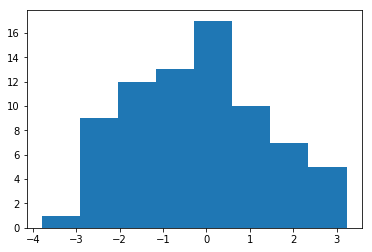

In [38]:
plt.hist(Fed.table['nashZ'], bins=8)

(array([3., 2., 7., 8., 5., 4., 1., 2.]),
 array([-1.90488788, -1.33347827, -0.76206867, -0.19065906,  0.38075055,
         0.95216016,  1.52356976,  2.09497937,  2.66638898]),
 <a list of 8 Patch objects>)

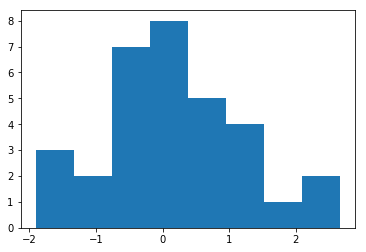

In [42]:
plt.hist(BoC.table['nashZ'], bins=8)

## Results

| Bank | $a_R$ | $a_L$ | $a_C$ | $b$ | $c$ | $\mu$ | $s$ | $p_C$ | $\sigma$ | $\epsilon$ |
|---|---|---|---|---|---|---|---|---|---|---|
| Bank of Canada Total SA|1.63409959|3.16218375|2.37604565|0.37368738|-0.81679396|1.13783871|3.74532325|1.0|0.78785134|0.2|
| Bank of Canada Total |1.74815774|3.26906496|2.45751539|0.33224235|-0.82289919|1.75681306|2.11248513|1.0|0.78725741|0.2|
| Bank of Canada Core CPI |1.80539449|3.84184997|2.7800699|0.19361319|-0.89938782|1.9975356|2.37650492|1.0|1.04782968|0.2|
| Fed |0.96405556|3.72723961|2.35336394|0.6964615|-2.69918336|-0.08721112|2.84102282|1.0|1.02183077|0.2|
|BoC Discrete Total |1.68744793|3.29453371|-1.09243813|0.33595219|-0.860996|9.17082977|7.95217247|0.41736977|1.0188812 |0.2|


In [ ]:
def monte_carlo(theta):
    

In [6]:
theta=[ 1.68744793,  3.29453371, -1.09243813,  0.33595219, -0.860996  ,
        9.17082977,  7.95217247,  0.41736977,  1.0188812 ,  0.2       ]

In [7]:
T = BoC.table['Date'].size

In [8]:
BoC.table['zeta'] = [0.05]*BoC.T

In [9]:
def giveRho(theta,zeta='zeta',target='Target',new=False,F=logistic.cdf):

    aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
    mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]

    i = self.table[target].copy()

    rho = pC*self.G(theta,zeta=zeta)+(1-pC)*((self.I(mu,b,c)+self.table[zeta]-i)/s).apply(F)
    rho[rho>1]=1; rho[rho<0]=0
    self.table['rho_zeta'] = rho.copy()   

    return rho


In [10]:
def gradNashFirst(theta): 

    aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
    mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]

    i = BoC.table['Target'].copy(); z = [zeta]*T
    BoC.giveRho(theta,zeta)
    rho = BoC.table['rho_zeta'].copy()
    
    comm = 1/2*(BoC.table['Target']-BoC.table['PriorTarget'])
    den = 2*(z+(BoC.I(aL,b,c,)+BoC.I(aR,b,c))/2-i)+\
            comm+comm*(aL-aR)*(pC/eps*BoC.g(theta)+(1-pC)/s*BoC.f((BoC.I(mu,b,c)+z-i)/s))

    dZdaR = -(z+(BoC.I(aL,b,c)-i)+comm*(1-rho))/den
    dZdaL = -(z+(BoC.I(aR,b,c)-i)+comm*rho)/den
    dZdaC = -pC/eps*BoC.g(theta)*comm*(aL-aR)*(-1)
    dZdMu = -(1-pC)/s*comm*(aL-aR)*BoC.f((BoC.I(mu,b,c)+z-i)/s)/den
    dZdS = (comm*(1-pC)*(aL-aR)*((BoC.I(mu,b,c)+z-i)/s**2)*\
            BoC.f((BoC.I(mu,b,c)+z-i)/s))/den
    dZdpC = -comm*(aL-aR)*(BoC.G(theta)-BoC.F((BoC.I(mu,b,c)+z-i)/s))/den

    gradaR = -(z*dZdaR)/sigma**2
    gradaL = -(z*dZdaL)/sigma**2
    gradaC = -(z*dZdaC)/sigma**2
    gradB = (z*BoC.table['Inflation'])/sigma**2
    gradC = (z*BoC.table['OutGap'])/sigma**2
    gradMu = -(z*dZdMu)/sigma**2
    gradS = -(z*dZdS)/sigma**2
    gradpC = -(z*dZdpC)/sigma**2
    gradSigma = (z**2)/sigma**3

    return(gradaR,gradaL,gradaC,gradB,gradC,gradMu,gradS,gradpC,gradSigma)

def gradNashSecond(theta):

    aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
    mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]

    numr = (BoC.table['zR']/sigma).apply(norm.pdf)-(BoC.table['zL']/sigma).apply(norm.pdf)
    den = (BoC.table['zR']/sigma).apply(norm.cdf)-(BoC.table['zL']/sigma).apply(norm.cdf)

    gradaR = -1/sigma*((BoC.table['zR']/sigma).apply(norm.pdf)/den)
    gradaL = 1/sigma*((BoC.table['zL']/sigma).apply(norm.pdf)/den)
    gradaC = pd.Series([0]*BoC.T)
    gradB = -1/sigma*(BoC.table['Inflation']*numr/den)
    gradC = -1/sigma*(BoC.table['OutGap']*numr/den)
    gradMu = pd.Series([0]*BoC.T)
    gradS = pd.Series([0]*BoC.T)
    gradpC = pd.Series([0]*BoC.T)
    gradSigma = -1/(sigma**2)*(BoC.table['zR']*(BoC.table['zR']/sigma).apply(norm.pdf)-\
                             BoC.table['zL']*(BoC.table['zL']/sigma).apply(norm.pdf))/den

    return(gradaR,gradaL,gradaC,gradB,gradC,gradMu,gradS,gradpC,gradSigma)

def gradNashThird(theta):

    i = BoC.table['Target'].copy(); z = [zeta]*T
    BoC.giveRho(theta,zeta=zeta)
    rho = BoC.table['rho_zeta'].copy()

    aR=theta[0]; aL=theta[1]; aC=theta[2]; b=theta[3]; c=theta[4];
    mu=theta[5]; s=theta[6]; pC=theta[7]; sigma=theta[8]; eps=theta[9]

    gradaR = pd.Series([0]*BoC.T)
    gradaL = pd.Series([0]*BoC.T)
    gradaC = z/sigma**2
    gradB = (z*BoC.table['Inflation'])/sigma**2
    gradC = (z*BoC.table['OutGap'])/sigma**2
    gradMu = pd.Series([0]*BoC.T)
    gradS = pd.Series([0]*BoC.T)
    gradpC = pd.Series([0]*BoC.T)
    gradSigma = (z**2)/sigma**3

    return(gradaR,gradaL,gradaC,gradB,gradC,gradMu,gradS,gradpC,gradSigma)

def gradNash(theta,**getRhoZ_kwargs):

    sigma = theta[-2]
    BoC.getRhoZ(theta,**getRhoZ_kwargs)

    gradaR=0.0; gradaL=0.0; gradaC=0.0; gradB=0.0; gradC=0.0; gradMu=0.0; gradS=0.0; gradpC=0.0; gradSigma=0.0
    grads = np.array([gradaR, gradaL, gradaC, gradB, gradC, gradMu, gradS, gradpC, gradSigma])
    for i in range(len(theta)-1):

        grads[i] = BoC.gradNashFirst(theta)[i].where(BoC.table['ChangeSign']!=0).where(BoC.table['Chairman_zeta']==0).sum()+\
                 BoC.gradNashSecond(theta)[i].where(BoC.table['ChangeSign']==0).sum()+\
                 BoC.gradNashThird(theta)[i].where(BoC.table['ChangeSign']!=0).where(BoC.table['Chairman_zeta']==1).sum()

    grads[8]=grads[8]-T/sigma

    return(grads)


In [22]:
def generate_one_estimate(theta, epseelon = 0.00001):

    BoC.giveRho(theta)
    BoC.chairmanHelper(theta)
    upper_pert = np.array([theta[i]+epseelon for i in range(len(theta)-4)])
    lower_pert = np.array([theta[i]-epseelon for i in range(len(theta)-4)])

    grad_upper = gradNash(upper_pert)
    grad_lower = gradNash(lower_pert)
    


In [24]:
theta

[1.68744793,
 3.29453371,
 -1.09243813,
 0.33595219,
 -0.860996,
 9.17082977,
 7.95217247,
 0.41736977,
 1.0188812,
 0.2]

In [23]:
generate_one_estimate(theta)

IndexError: index 6 is out of bounds for axis 0 with size 6